In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
# TODO: automate with nice data configs of selected variables etc.
# TODO: logging functions

from pathlib import Path
import xarray as xa
import geopandas as gpd
from datetime import datetime
import dask
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm import tqdm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from dask.distributed import Client, LocalCluster
import dask
import xgboost as xgb

from sklearn.metrics import mean_squared_error
import dask_ml.model_selection as dcv
from scipy.stats import expon
from sklearn import svm, datasets


from coralshift.dataloading import config, get_data
from coralshift import functions_creche
from coralshift.processing import spatial_data
from coralshift.machine_learning import baselines
from coralshift.plotting import spatial_plots

data_fp = config.data_folder

ERROR 1: PROJ: proj_create_from_database: Open of /home/jovyan/lustre_scratch/conda-envs/coralshift/share/proj failed


In [3]:
resolution_lat, resolution_lon = 0.01, 0.01

# ((X_train, y_train), (X_test, y_test)), dfs_list = get_data.get_data("rf", resolution_lat, resolution_lon)
# common_df = get_data.get_data("transformer", resolution_lat, resolution_lon)

In [163]:
def split_dataset_and_save(ds_fp, divisor, output_dir_name: str=None, select_vars: list[str]=None):
    
    ds = xa.open_dataset(ds_fp)
    
    if select_vars:
        ds = ds[select_vars]
            
    subsets_dict = split_dataset_by_indices(ds, divisor)
    
    # Create a subdirectory to save the split datasets
    if output_dir_name:
        output_dir = Path(ds_fp).parent / f"{output_dir_name}_{divisor**2}_split_datasets"
    else:
        output_dir = Path(ds_fp).parent / f"{divisor**2}_split_datasets"
    output_dir.mkdir(parents=True, exist_ok=True)

    
    for coord_info, subset in tqdm(subsets_dict.items(), desc="saving dataset subsets..."):
        stem_stem = str(Path(ds_fp).stem).split("lats")[0]
        # Construct the filename based on bounds
        filename = f"{stem_stem}_{coord_info}.nc"
        save_fp = output_dir / filename
        subset.to_netcdf(save_fp)
    return subsets_dict
    

def split_dataset_by_indices(dataset, divisor) -> dict:
    subsets_dict = {}
    num_lats = len(dataset.latitude.values) // divisor
    num_lons = len(dataset.longitude.values) // divisor
    for i in range(divisor):
        for j in range(divisor):
            start_lat_ind = i * num_lats
            start_lon_ind = j * num_lons
            
            subset = dataset.isel(latitude=slice(start_lat_ind, start_lat_ind + num_lats),
                                  longitude=slice(start_lon_ind, start_lon_ind + num_lons))
            
            lat_lims = spatial_data.min_max_of_coords(subset, "latitude")
            lon_lims = spatial_data.min_max_of_coords(subset, "longitude")
            
            coord_info = functions_creche.tuples_to_string(lat_lims, lon_lims)
            subsets_dict[coord_info] = subset
    
    return subsets_dict


def ds_to_ml_ready(ds, 
    gt:str="unep_coral_presence", exclude_list: list[str]=["latitude", "longitude", "latitude_grid", "longitude_grid", "crs", "depth", "spatial_ref"], 
    train_val_test_frac=[1,0,0], inf_type: str="classification", threshold=0.5, depth_mask_lims = [-50, 0], client=None, remove_rows:bool=False):
    
    df = ds.compute().to_dataframe()
    # TODO: implement checking for empty dfs

    predictors = [pred for pred in df.columns if pred != gt and pred not in exclude_list]
    depth_condition = (df["elevation"] < max(depth_mask_lims)) & (df["elevation"] > min(depth_mask_lims))
    
    if remove_rows:
        df = df[depth_condition]
    else:
        df["within_depth"] = 0
        df.loc[depth_condition, "within_depth"] = 1
        
    if len(df) > 0:
        scaler = MinMaxScaler()
        df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index = df.index)
    
    df["nan_onehot"] = df.isna().any(axis=1).astype(int)
    df = df.fillna(0)
    
#     X = df[predictors].to_numpy()
#     y = df[gt].to_numpy()
    
    X = df[predictors]
    y = df[gt]
    
    return X, y

def cont_to_class(array, threshold=0.5):
    array[array >= threshold] = 1
    array[array < threshold] = 0

    return array.astype(int)

In [112]:
train_nc_fps

[PosixPath('data/64_split_datasets/temp_rf__lats_-32--28_lons_130-135.nc'),
 PosixPath('data/64_split_datasets/temp_rf__lats_-16--12_lons_145-150.nc'),
 PosixPath('data/64_split_datasets/temp_rf__lats_-8--4_lons_140-145.nc'),
 PosixPath('data/64_split_datasets/temp_rf__lats_-12--8_lons_160-165.nc'),
 PosixPath('data/64_split_datasets/temp_rf__lats_-20--16_lons_145-150.nc')]

In [158]:
num_files = 10
train_nc_fps = list(Path("data/64_split_datasets").glob("temp_rf*.nc"))[:num_files]
test_nc_fps = list(Path("data/64_split_datasets").glob("temp_rf*.nc"))[num_files:num_files + num_files]


train_Xs, train_ys = [], []
for i, fp in enumerate(train_nc_fps):
    ds = xa.open_dataset(fp)
    X, y = ds_to_ml_ready(ds, remove_rows=True)
    train_Xs.append(X)
    train_ys.append(y)
    
test_Xs, test_ys = [], []
for i, fp in enumerate(test_nc_fps):
    ds = xa.open_dataset(fp)
    X, y = ds_to_ml_ready(ds, remove_rows=True)
    test_Xs.append(X)
    test_ys.append(y)

In [159]:
train_Xs = pd.concat(train_Xs, axis=0)
train_ys = pd.concat(train_ys, axis=0)

test_Xs = pd.concat(test_Xs, axis=0)
test_ys = pd.concat(test_ys, axis=0)

In [161]:
len(train_ys)

139183

In [102]:
# f,ax=plt.subplots(ncols=len(Xs), subplot_kw={"projection": ccrs.PlateCarree()})
# # das = []
# for i, df in enumerate(Xs):
#     ds = spatial_data.process_xa_d(df.to_xarray())
#     spatial_plots.plot_spatial(ds["elevation"], fax=(f,ax[i]))
    

(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'elevation at 0.0268° (~2907 m) resolution'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f204416bf40>)

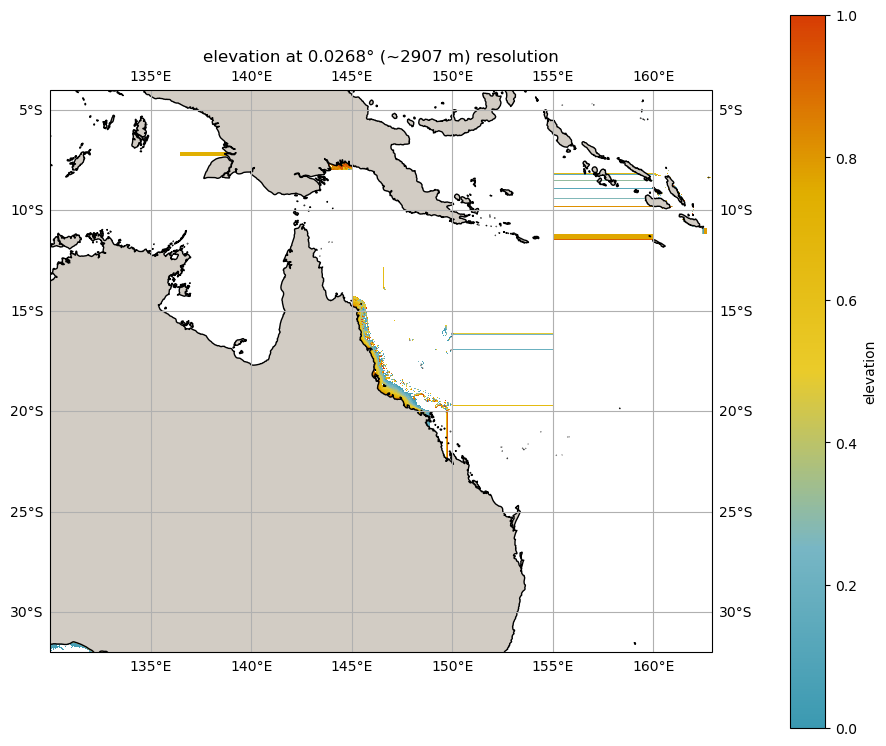

In [72]:
spatial_plots.plot_spatial(pd.concat(Xs, axis=0).to_xarray()["elevation"])

In [104]:
test_ds = spatial_data.process_xa_d(ds_to_ml_ready(subset_list[1])[0].to_xarray())

KeyboardInterrupt: 

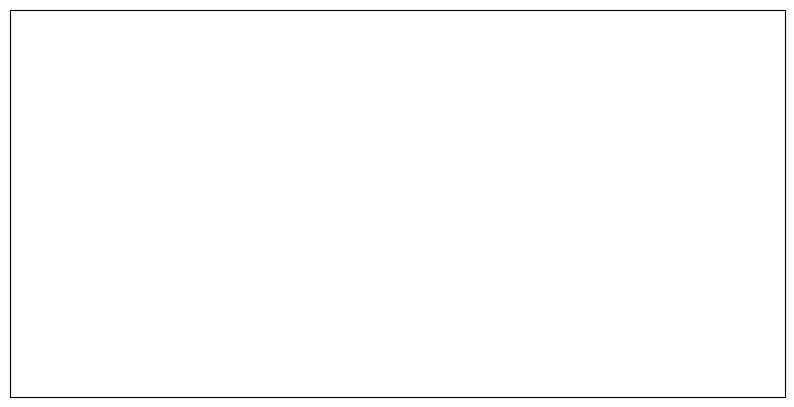

In [105]:
spatial_plots.plot_spatial(test_ds["elevation"])

In [47]:
# rf_ds = xa.open_dataset("data/temp_rf_lats_-32-0_lons_130-170_ds.nc", chunks="auto")
# rf_ds

trans_ds = xa.open_dataset("data/temp_trans_lats_-32-0_lons_130-170_ds.nc", chunks="auto")
trans_preds = ["uo","vo","so","thetao","tos","elevation","seafloor_slope"]
gt = "unep_coral_presence"
# split_dataset_and_save(ds_fp="data/temp_trans_lats_-32-0_lons_130-170_ds.nc", divisor=8, output_dir_name="trans", select_vars=trans_preds+[gt])


/lustre_scratch/orlando-code/coralshift/coralshift/plotting/spatial_plots.py:205: RuntimeWarning: All-NaN slice encountered
  vmin, vmax = np.nanmin(xa_da.values), np.nanmax(xa_da.values)


(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'so at 0.0100° (~1085 m) resolution'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f6e3e7b0fd0>)

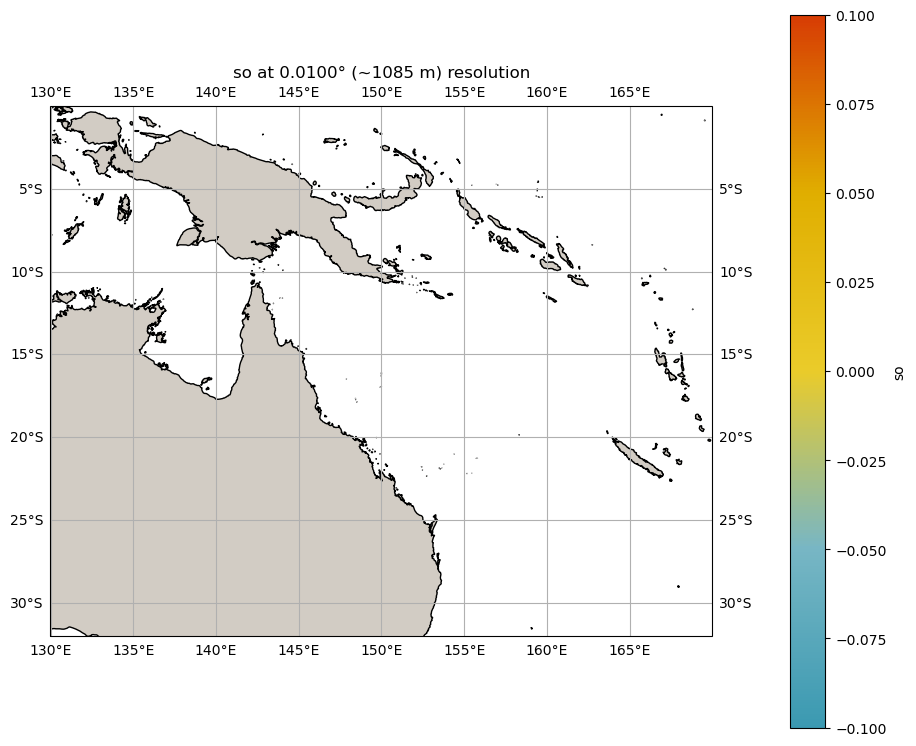

In [49]:
spatial_plots.plot_spatial(trans_ds["so"].isel(time=100))

In [32]:
trans_subset1 = xa.open_dataset("data/64_split_datasets/temp_trans__lats_-12--8_lons_130-135.nc").compute()
trans_subset2 = xa.open_dataset("data/64_split_datasets/temp_trans__lats_-20--16_lons_150-155.nc").compute()
trans_subset_list = [trans_subset1, trans_subset2]

In [ ]:
# buffered_evs = xa.open_dataset("data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/uo_so_vo_thetao_tos_buffered.nc", chunks="auto")
get_data.get_data("transformer", 0.01, 0.01)


loading cmip data...
loading gebco data...
loading unep-wcmc data...
spatially aligning datasets...


resampling and merging 4 datasets: 100%|██████████| 4/4 [00:00<00:00, 11.47it/s]


/lustre_scratch/orlando-code/coralshift/coralshift/plotting/spatial_plots.py:205: RuntimeWarning: All-NaN slice encountered
  vmin, vmax = np.nanmin(xa_da.values), np.nanmax(xa_da.values)


(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'uo at 0.0100° (~1085 m) resolution'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f24481bebf0>)

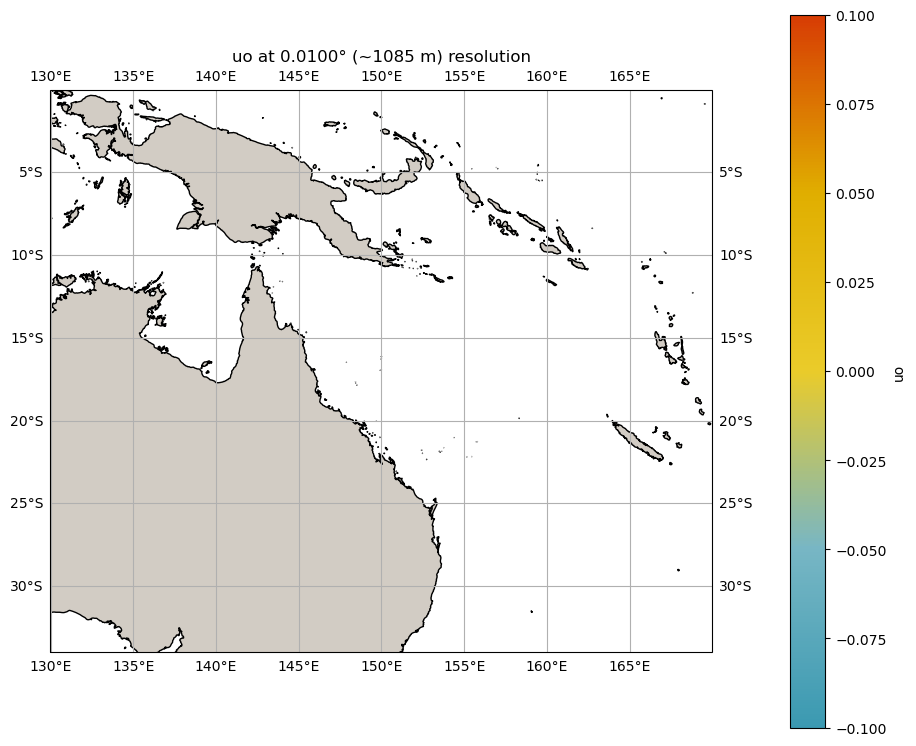

In [3]:
spatial_plots.plot_spatial(xa.open_dataset("data/temp_transformer_lats_-34-0_lons_130-170_ds.nc", chunks="auto")["uo"].isel(time=100))

/lustre_scratch/orlando-code/coralshift/coralshift/plotting/spatial_plots.py:205: RuntimeWarning: All-NaN slice encountered
  vmin, vmax = np.nanmin(xa_da.values), np.nanmax(xa_da.values)
/lustre_scratch/orlando-code/coralshift/coralshift/plotting/spatial_plots.py:205: RuntimeWarning: All-NaN slice encountered
  vmin, vmax = np.nanmin(xa_da.values), np.nanmax(xa_da.values)


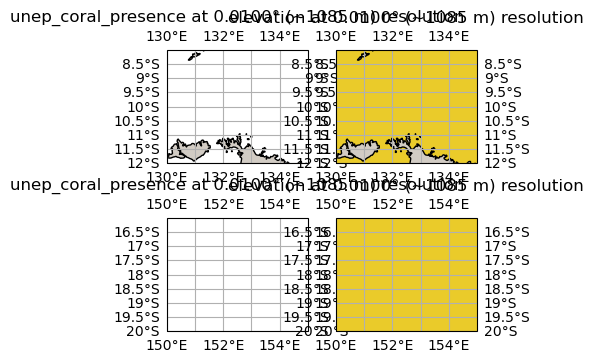

In [39]:
min_depth, max_depth = -100, 0

f,ax = plt.subplots(ncols=len(trans_subset_list), nrows=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=[4,4])
for s, trans_subset in enumerate(trans_subset_list):
    mask = (trans_subset["elevation"] > min_depth) & (trans_subset["elevation"] < max_depth)
    spatial_plots.plot_spatial(trans_subset["unep_coral_presence"], fax=(f,ax[s,0]), title="", cbar=False)
    spatial_plots.plot_spatial(mask, fax=(f,ax[s,1]), title="", cbar=False)


In [36]:
X_train_trans, y_train_trans = ds_to_ml_ready(trans_subset_list[0])
X_test_trans, y_test_trans = ds_to_ml_ready(trans_subset_list[1])

['uo', 'vo', 'so', 'thetao', 'tos', 'elevation', 'seafloor_slope']
0


ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by MinMaxScaler.

In [4]:
subset1 = xa.open_dataset("data/64_split_datasets/temp_rf__lats_-12--8_lons_130-135.nc").compute()
subset2 = xa.open_dataset("data/64_split_datasets/temp_rf__lats_-20--16_lons_150-155.nc").compute()

subset_list = [subset1, subset2]

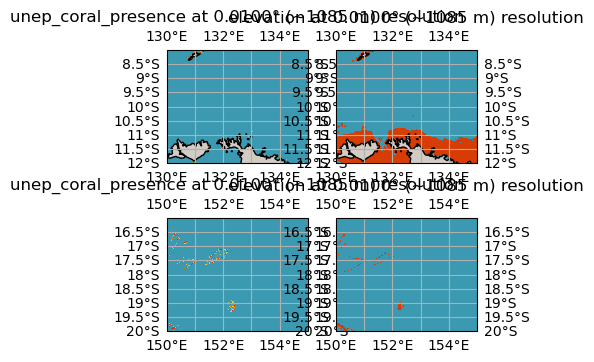

In [13]:
min_depth, max_depth = -50, 0

f,ax = plt.subplots(ncols=len(subset_list), nrows=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=[4,4])
for s, subset in enumerate(subset_list):
    mask = (subset["elevation"] > min_depth) & (subset["elevation"] < max_depth)
    spatial_plots.plot_spatial(subset["unep_coral_presence"], fax=(f,ax[s,0]), title="", cbar=False)
    spatial_plots.plot_spatial(mask, fax=(f,ax[s,1]), title="", cbar=False)


In [14]:


# def compare_regions()

(array([35254.,   164.,   216.,   137.,   125.,    68.,   183.,   237.,
          134.,   523.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

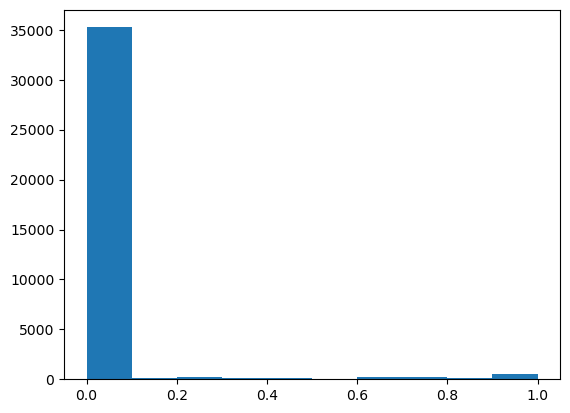

In [17]:
plt.hist(y_train)

In [18]:
(len(y_test)-sum(y_test))/sum(y_test)

1.8336027884532693

In [368]:
# from numpy import mean
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from xgboost import XGBClassifier
# # generate dataset
# X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
#  n_clusters_per_class=2, weights=[0.5], flip_y=0, random_state=7)

# y[:10]

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 1])

In [167]:
from dask_ml.model_selection import RandomizedSearchCV as dask_RandomizedSearchCV

In [ ]:
# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the RandomizedSearchCV object
clf = dask_RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='roc_auc')

clf.fit(X_train, y_train)

In [ ]:
clf.cv_results_
# clf.get_xgb_params()

In [164]:
# import sklearn.metrics as sklmetrics
# sklmetrics.get_scorer_names()

X_train, y_train = train_Xs.to_numpy(), cont_to_class(train_ys.to_numpy(), threshold=threshold)


# define model
model = xgb.XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

KeyboardInterrupt: 

Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2023-11-21 01:48:43,587 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/nanny.py", line 999, in _run
    asyncio.run(run())
  File "/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/asyncio/runners.py", line 44, in run
    return loop.run_until_complete(main)
  File "/home/jovyan/lustre_

In [156]:
y_test[:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1.])

In [148]:
# TODO
# implement balancing class difference
# hypertune both

import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV


    
threshold=0.25
model_type = "regression"
# model_type = "classification"

# X_train, y_train = ds_to_ml_ready(train_dss)
# X_test, y_test = ds_to_ml_ready(test_dss)
X_train, y_train = train_Xs.to_numpy(), train_ys.to_numpy()
X_test, y_test = test_Xs.to_numpy()[:10000], test_ys.to_numpy()[:10000]

# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)

if model_type == "classification":
    y_train = cont_to_class(y_train, threshold=threshold)
    y_test = cont_to_class(y_test, threshold=threshold)
    
    model = xgb.XGBClassifier(scale_pos_weight=(len(y_test)-sum(y_test))/sum(y_test))
    
elif model_type == "regression":
    model = xgb.XGBRegressor(
        n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, scale_pos_weight=(len(y_test)-sum(y_test))/sum(y_test)
    )


# Create the XGBoost DMatrices
dtrain = xgb.dask.DaskDMatrix(client, dask.array.from_array(X_train),  dask.array.from_array(y_train))
dtest = xgb.dask.DaskDMatrix(client, dask.array.from_array(X_test),  dask.array.from_array(y_test))

param_dict = {
    # 'n_estimators': 100,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "random_state": 42,
}

# train the model
output = xgb.dask.train(
    client, param_dict, dtrain, num_boost_round=1000, evals=[(dtrain, "train")]
)

# model_type = "brt"
# model, data_type = baselines.initialise_model(model_type)
# search_grid = baselines.ModelInitializer().get_search_grid(model_type)


/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42769 instead
  warnings.warn(
[01:30:56] task [xgboost.dask-2]:tcp://127.0.0.1:35459 got new rank 0


[0]	train-rmse:0.46872
[1]	train-rmse:0.43543
[2]	train-rmse:0.40564
[3]	train-rmse:0.37971
[4]	train-rmse:0.36030
[5]	train-rmse:0.33991
[6]	train-rmse:0.32199
[7]	train-rmse:0.30654
[8]	train-rmse:0.29301
[9]	train-rmse:0.28322
[10]	train-rmse:0.27290
[11]	train-rmse:0.26402
[12]	train-rmse:0.25597
[13]	train-rmse:0.24826
[14]	train-rmse:0.24392
[15]	train-rmse:0.23855
[16]	train-rmse:0.23523
[17]	train-rmse:0.23101
[18]	train-rmse:0.22763
[19]	train-rmse:0.22427
[20]	train-rmse:0.22153
[21]	train-rmse:0.21980
[22]	train-rmse:0.21791
[23]	train-rmse:0.21632
[24]	train-rmse:0.21378
[25]	train-rmse:0.21187
[26]	train-rmse:0.20979
[27]	train-rmse:0.20845
[28]	train-rmse:0.20769
[29]	train-rmse:0.20662
[30]	train-rmse:0.20498
[31]	train-rmse:0.20376
[32]	train-rmse:0.20280
[33]	train-rmse:0.20184
[34]	train-rmse:0.20065
[35]	train-rmse:0.19992
[36]	train-rmse:0.19895
[37]	train-rmse:0.19830
[38]	train-rmse:0.19782
[39]	train-rmse:0.19728
[40]	train-rmse:0.19658
[41]	train-rmse:0.19608
[4

In [150]:
# make predictions
y_test_pred = xgb.dask.predict(client, output, dtest).compute()
y_train_pred = xgb.dask.predict(client, output, dtrain).compute() # overfitting test

In [21]:
y_train_pred

array([8.4525663e-03, 4.7089183e-04, 1.0831353e-03, ..., 8.9131516e-01,
       9.6771854e-01, 9.9288303e-01], dtype=float32)

(array([42825.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  8457.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

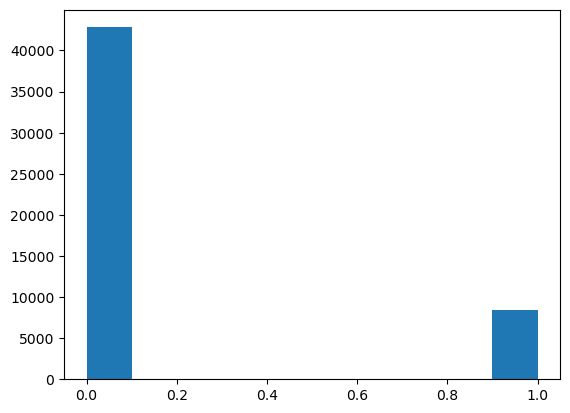

In [152]:
plt.hist(y_train)

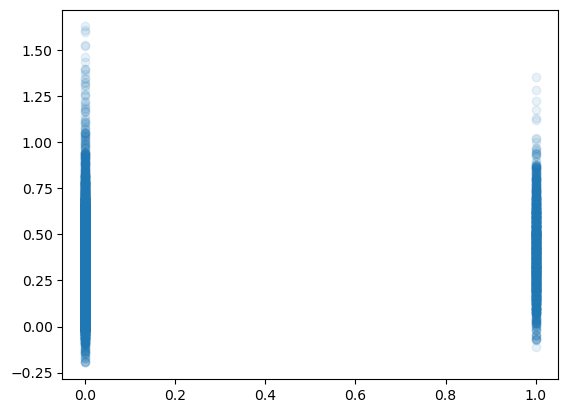

In [157]:
# plt.scatter(y_train,y_train_pred, alpha=0.1) #overfit
plt.scatter(y_test,y_test_pred, alpha=0.1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cm = confusion_matrix(y_test, y_test_pred, labels=["presence", "absence"])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                                display_labels=["presence", "absence"])

In [206]:
gt = "unep_coral_presence"
exclude_list = []
train_val_test_frac = [0.8,0,0.2]
inf_type = "classification"
threshold = 0.5
depth_mask_lims = [-50, 0]

cluster = LocalCluster(n_workers=4)
client = Client(cluster)
# client
    

/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33859 instead
  warnings.warn(


In [208]:
df_dask = subset.to_dask_dataframe()


In [215]:
# df_dask = ds.to_dask_dataframe()
df_dask = client.persist(df_dask)

df_nonans = df_dask.fillna(0)
# apply shallow water mask
df_shallow = df_filled[(df_nonans["elevation"] < max(depth_mask_lims)) & (df_nonans["elevation"] > min(depth_mask_lims))]

In [213]:
# df_shallow.latitude.values.compute()[:3]

In [220]:
# scaler = dMinMaxScaler()
# df_scaled = scaler.fit_transform(df_shallow)


In [9]:


# subsets = split_dataset_and_save(ds_fp="data/temp_rf_lats_-32-0_lons_130-170_ds.nc", divisor=divisor)

In [90]:
subset

<xarray.Dataset>
Dimensions:                (latitude: 425, longitude: 500)
Coordinates:
  * latitude               (latitude) float64 -20.0 -19.99 ... -15.77 -15.76
  * longitude              (longitude) float64 147.0 147.0 147.0 ... 152.0 152.0
    spatial_ref            int64 ...
    crs                    int64 ...
Data variables: (12/203)
    so_january_mean        (latitude, longitude) float32 dask.array<chunksize=(425, 500), meta=np.ndarray>
    so_february_mean       (latitude, longitude) float32 dask.array<chunksize=(425, 500), meta=np.ndarray>
    so_march_mean          (latitude, longitude) float32 dask.array<chunksize=(425, 500), meta=np.ndarray>
    so_april_mean          (latitude, longitude) float32 dask.array<chunksize=(425, 500), meta=np.ndarray>
    so_may_mean            (latitude, longitude) float32 dask.array<chunksize=(425, 500), meta=np.ndarray>
    so_june_mean           (latitude, longitude) float32 dask.array<chunksize=(425, 500), meta=np.ndarray>
    ...                     ...
    vo_jan_std             (latitude, longitude) float32 dask.array<chunksize=(425, 500), meta=np.ndarray>
    vo_jul_std             (latitude, longitude) float32 dask.array<chunksize=(425, 500), meta=np.ndarray>
    vo_overall_mean        (latitude, longitude) float32 dask.array<chunksize=(425, 500), meta=np.ndarray>
    elevation              (latitude, longitude) float64 dask.array<chunksize=(425, 500), meta=np.ndarray>
    seafloor_slope         (latitude, longitude) float64 dask.array<chunksize=(425, 500), meta=np.ndarray>
    unep_coral_presence    (latitude, longitude) float64 dask.array<chunksize=(425, 500), meta=np.ndarray>

In [91]:
# # start_lat_ind, start_lon_ind = 1600, 1700

# # subset = rf_ds.isel(latitude=slice(start_lat_ind,start_lat_ind+num_lats), longitude=slice(start_lon_ind,start_lon_ind+num_lons))
# # spatial_plots.plot_spatial(subset["unep_coral_presence"])

# start_lat_ind, start_lon_ind = 1200, 1700

# subset = rf_ds.isel(latitude=slice(start_lat_ind,start_lat_ind+num_lats), longitude=slice(start_lon_ind,start_lon_ind+num_lons))
# spatial_plots.plot_spatial(subset["unep_coral_presence"])

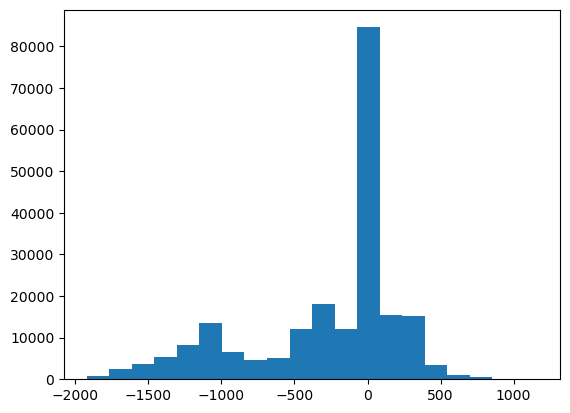

In [15]:
import matplotlib.pyplot as plt
plt.hist(subset["elevation"].values.flatten(), bins=20);

In [195]:
from dask_ml.preprocessing import MinMaxScaler as dMinMaxScaler

# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)


def ds_to_ml_ready(ds, gt:str="unep_coral_presence", exclude_list: list[str]=[], train_val_test_frac=[0.8,0,0.2], inf_type: str="classification", threshold=0.5, depth_mask_lims = [-50, 0], client=None):
    subset_df = subset.to_dask_dataframe()
    exclude_list += ["crs", "depth", "spatial_ref"]
    predictors = [pred
    for pred in subset_df.columns
    if pred != gt and pred not in exclude_list
]
    
    if not client:
        # local dask cluster
        cluster = LocalCluster(n_workers=4)
        client = Client(cluster)
        client

    df_dask = ds.to_dask_dataframe()
    df_dask = client.persist(df_dask)

    # apply shallow water mask
    df_shallow = df_filled[(df_filled["elevation"] < max(depth_mask_lims)) & (df_filled["elevation"] > min(depth_mask_lims))]
    
    scaler = dMinMaxScaler()
    df_scaled = scaler.fit_transform(df_shallow)
    df_scaled = df_scaled.fillna(0)

    
    X = df_scaled[predictors]
    y = df_scaled[gt]
    
#     if inf_type == "classification":
#         y.loc[y >= threshold] = 1
#         y.loc[y < threshold] = 0

    return X, y#, df_filled

X, y = ds_to_ml_ready(
    subset,
#     subset.isel(latitude=slice(0, 10), longitude=slice(0, 10)),
     client = client
)
    


/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40137 instead
  warnings.warn(
Task exception was never retrieved
future: <Task finished name='Task-2656538' coro=<Client._gather.<locals>.wait() done, defined at /home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-2716204' coro=<Client._gather.<locals>.wait() done, defined at /home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most

KeyError: "['so_january_mean', 'so_february_mean', 'so_march_mean', 'so_april_mean', 'so_may_mean', 'so_june_mean', 'so_july_mean', 'so_august_mean', 'so_september_mean', 'so_october_mean', 'so_november_mean', 'so_december_mean', 'so_january_max', 'so_january_min', 'so_february_max', 'so_february_min', 'so_march_max', 'so_march_min', 'so_april_max', 'so_april_min', 'so_may_max', 'so_may_min', 'so_june_max', 'so_june_min', 'so_july_max', 'so_july_min', 'so_august_max', 'so_august_min', 'so_september_max', 'so_september_min', 'so_october_max', 'so_october_min', 'so_november_max', 'so_november_min', 'so_december_max', 'so_december_min', 'so_time_std', 'so_jan_std', 'so_jul_std', 'so_overall_mean', 'thetao_january_mean', 'thetao_february_mean', 'thetao_march_mean', 'thetao_april_mean', 'thetao_may_mean', 'thetao_june_mean', 'thetao_july_mean', 'thetao_august_mean', 'thetao_september_mean', 'thetao_october_mean', 'thetao_november_mean', 'thetao_december_mean', 'thetao_january_max', 'thetao_january_min', 'thetao_february_max', 'thetao_february_min', 'thetao_march_max', 'thetao_march_min', 'thetao_april_max', 'thetao_april_min', 'thetao_may_max', 'thetao_may_min', 'thetao_june_max', 'thetao_june_min', 'thetao_july_max', 'thetao_july_min', 'thetao_august_max', 'thetao_august_min', 'thetao_september_max', 'thetao_september_min', 'thetao_october_max', 'thetao_october_min', 'thetao_november_max', 'thetao_november_min', 'thetao_december_max', 'thetao_december_min', 'thetao_time_std', 'thetao_jan_std', 'thetao_jul_std', 'thetao_overall_mean', 'tos_january_mean', 'tos_february_mean', 'tos_march_mean', 'tos_april_mean', 'tos_may_mean', 'tos_june_mean', 'tos_july_mean', 'tos_august_mean', 'tos_september_mean', 'tos_october_mean', 'tos_november_mean', 'tos_december_mean', 'tos_january_max', 'tos_january_min', 'tos_february_max', 'tos_february_min', 'tos_march_max', 'tos_march_min', 'tos_april_max', 'tos_april_min', 'tos_may_max', 'tos_may_min', 'tos_june_max', 'tos_june_min', 'tos_july_max', 'tos_july_min', 'tos_august_max', 'tos_august_min', 'tos_september_max', 'tos_september_min', 'tos_october_max', 'tos_october_min', 'tos_november_max', 'tos_november_min', 'tos_december_max', 'tos_december_min', 'tos_time_std', 'tos_jan_std', 'tos_jul_std', 'tos_overall_mean', 'uo_january_mean', 'uo_february_mean', 'uo_march_mean', 'uo_april_mean', 'uo_may_mean', 'uo_june_mean', 'uo_july_mean', 'uo_august_mean', 'uo_september_mean', 'uo_october_mean', 'uo_november_mean', 'uo_december_mean', 'uo_january_max', 'uo_january_min', 'uo_february_max', 'uo_february_min', 'uo_march_max', 'uo_march_min', 'uo_april_max', 'uo_april_min', 'uo_may_max', 'uo_may_min', 'uo_june_max', 'uo_june_min', 'uo_july_max', 'uo_july_min', 'uo_august_max', 'uo_august_min', 'uo_september_max', 'uo_september_min', 'uo_october_max', 'uo_october_min', 'uo_november_max', 'uo_november_min', 'uo_december_max', 'uo_december_min', 'uo_time_std', 'uo_jan_std', 'uo_jul_std', 'uo_overall_mean', 'vo_january_mean', 'vo_february_mean', 'vo_march_mean', 'vo_april_mean', 'vo_may_mean', 'vo_june_mean', 'vo_july_mean', 'vo_august_mean', 'vo_september_mean', 'vo_october_mean', 'vo_november_mean', 'vo_december_mean', 'vo_january_max', 'vo_january_min', 'vo_february_max', 'vo_february_min', 'vo_march_max', 'vo_march_min', 'vo_april_max', 'vo_april_min', 'vo_may_max', 'vo_may_min', 'vo_june_max', 'vo_june_min', 'vo_july_max', 'vo_july_min', 'vo_august_max', 'vo_august_min', 'vo_september_max', 'vo_september_min', 'vo_october_max', 'vo_october_min', 'vo_november_max', 'vo_november_min', 'vo_december_max', 'vo_december_min', 'vo_time_std', 'vo_jan_std', 'vo_jul_std', 'vo_overall_mean'] not in index"

In [169]:
len(X)

37041

In [119]:
subset = xa.open_dataset("data/64_split_datasets/temp_rf_lats_-32-0_lons_130-170_ds_lats_-12--8_lons_130-135.nc", chunks="auto")
subset_df = subset[["elevation", "seafloor_slope", "unep_coral_presence"]].to_dask_dataframe()

In [113]:
gt = "unep_coral_presence"
exclude_list = ["crs", "depth", "spatial_ref"]
depth_mask_lims = [-50, 0]

predictors = [pred for pred in subset_df.columns
    if pred != gt and pred not in exclude_list
]

In [122]:
df_filled = subset_df.fillna(0)
df_shallow = df_filled[(df_filled["elevation"] < max(depth_mask_lims)) & (df_filled["elevation"] > min(depth_mask_lims))]

In [129]:
df_part = df_shallow.repartition(npartitions)

In [151]:
# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)
client

df_subset = subset.to_dask_dataframe()

df_subset = client.persist(df_subset)

/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41903 instead
  warnings.warn(


In [152]:
from dask_ml.preprocessing import MinMaxScaler as dMinMaxScaler

scaler = dMinMaxScaler()

scaler.fit_transform(df_subset).head()

,latitude,longitude,spatial_ref,crs,so_january_mean,so_february_mean,so_march_mean,so_april_mean,so_may_mean,so_june_mean,...,vo_november_min,vo_december_max,vo_december_min,vo_time_std,vo_jan_std,vo_jul_std,vo_overall_mean,elevation,seafloor_slope,unep_coral_presence
0,0.0,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0.0,0.002004,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.905852,0.019826,0.0
2,0.0,0.004008,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.905247,0.011122,0.0
3,0.0,0.006012,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.903293,0.022727,0.0
4,0.0,0.008016,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.905573,0.023694,0.0


In [127]:
df_scaled = dask.dataframe(scaler.fit_transform(df_part), columns=df_part.columns)

KeyboardInterrupt: 

In [95]:
# # X_train_scaled_df, X_test_scaled_df = preprocess_data(common_df, label_column=gt)
# (
#     (X_train, y_train),
#     (_, _),
#     (X_test, y_test),
# ), dfs_list = functions_creche.process_df_for_rfr(
#     common_df, predictors, gt, train_val_test_frac=train_val_test_frac
# )

In [20]:
# common_df.isnull().any(axis=1).sum() / len(common_df)

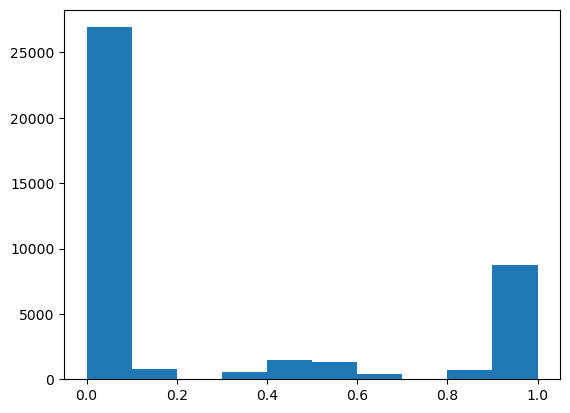

In [153]:
plt.hist(df_scaled["unep_coral_presence"].values);

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sum(y_test)

2023-11-20 14:21:18,054 - distributed.worker - WARNING - Compute Failed
Key:       ('len-chunk-ab859caed872ec2450b9b956f92a3a06-13d0bfeae48b7d9b45dc59f64448cfc8', 0)
Function:  subgraph_callable-89c2c4dd-4192-407c-a2e0-f53241e4
args:      ('latitude', ['latitude', 'longitude', 'so_january_mean', 'so_february_mean', 'so_march_mean', 'so_april_mean', 'so_may_mean', 'so_june_mean', 'so_july_mean', 'so_august_mean', 'so_september_mean', 'so_october_mean', 'so_november_mean', 'so_december_mean', 'so_january_max', 'so_january_min', 'so_february_max', 'so_february_min', 'so_march_max', 'so_march_min', 'so_april_max', 'so_april_min', 'so_may_max', 'so_may_min', 'so_june_max', 'so_june_min', 'so_july_max', 'so_july_min', 'so_august_max', 'so_august_min', 'so_september_max', 'so_september_min', 'so_october_max', 'so_october_min', 'so_november_max', 'so_november_min', 'so_december_max', 'so_december_min', 'so_time_std', 'so_jan_std', 'so_jul_std', 'so_overall_mean', 'thetao_january_mean', 'thetao

AttributeError: 'str' object has no attribute 'fillna'

In [22]:
import xgboost as xgb

from dask.distributed import Client, LocalCluster
import dask

# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)
client


model = xgb.XGBClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [60]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score, mean_squared_error

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),eval_metric="auc",early_stopping_rounds=10)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print(f"SCORE: {accuracy}")
    return {'loss': -accuracy, 'status': STATUS_OK }



In [ ]:
trials = Trials()
# takes a while to run
# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [175]:
X.head(10)

KeyboardInterrupt: 

In [173]:
best_hyperparams = {'colsample_bytree': 0.950546832705698, 'gamma': 1.2728166785185486, 'max_depth': 12.0, 'min_child_weight': 9.0, 'reg_alpha': 49.0, 'reg_lambda': 0.9628698105666551}
# set necessary values to int
best_hyperparams["max_depth"] = int(best_hyperparams["max_depth"])
best_hyperparams["min_child_weight"] = int(best_hyperparams["min_child_weight"])

xgb_clf = xgb.XGBClassifier(**best_hyperparams, eval_metric="auc")

xgb_clf.fit(X.iloc[:10],y.iloc[:10])

NotImplementedError: 'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.

In [ ]:
# plt.scatter(y_test, xgb_clf.predict(X_test))
# mean_squared_error(y_test, xgb_clf.predict(X_test))
xgb_clf.predict_proba(X_test)

In [25]:
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.98348


In [149]:
sum(y_train)/(len(y_train)-sum(y_train))

0.4961759082217973

(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'elevation at 0.0100° (~1085 m) resolution'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f063e6af4f0>)

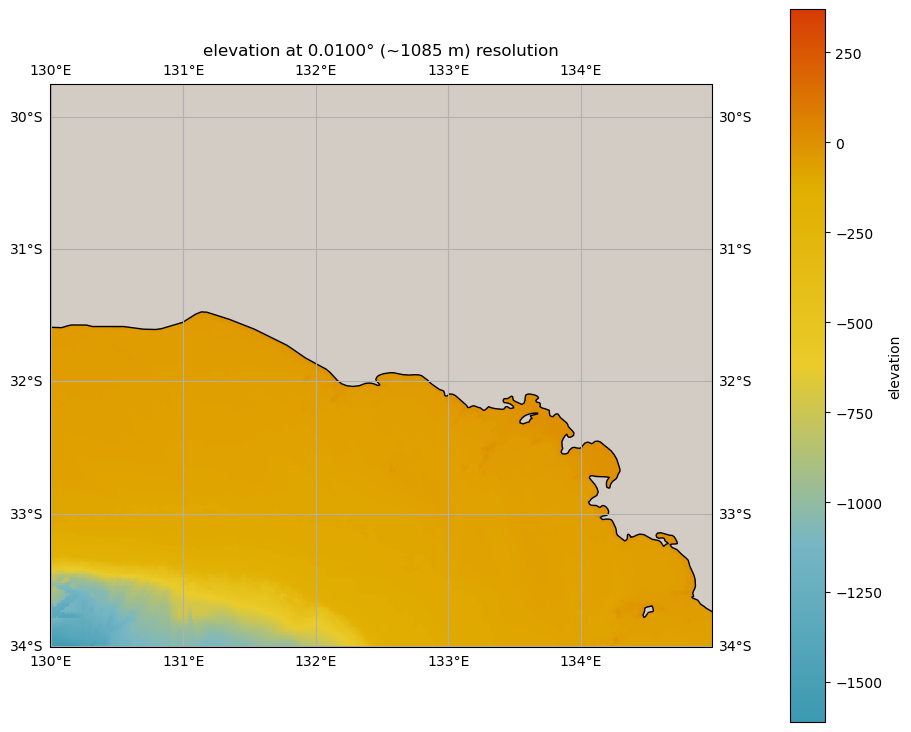

In [47]:
from coralshift.plotting import spatial_plots
spatial_plots.plot_spatial(subset["elevation"])

In [8]:
gt = "unep_coral_presence"
exclude_list = []
exclude_list += ["crs", "depth", "spatial_ref"]
predictors = [
    pred
    for pred in common_df.columns
    if pred != gt and pred not in exclude_list
        ]
# common_df

In [9]:
from dask_ml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(common_df[predictors], common_df[gt], shuffle=True)

In [10]:
y_train.head()

KeyboardInterrupt: 

In [20]:
from dask_ml.wrappers import Incremental
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
inc = Incremental(rfr, scoring="accuracy")


In [179]:
# inc.fit(X_train, y_train)

In [191]:
X_array = X.to_dask_array(lengths=True)
# dtrain = xgb.dask.DaskDMatrix(client, X.to_dask_array(), y.to_dask_array())


2023-11-20 14:19:25,280 - distributed.worker - WARNING - Compute Failed
Key:       ('len-befb09af9c20254df8a752636efac4a4', 0)
Function:  subgraph_callable-7e9abd9d-6407-48a3-ba5c-cf7af3f9
args:      (['latitude', 'longitude', 'so_january_mean', 'so_february_mean', 'so_march_mean', 'so_april_mean', 'so_may_mean', 'so_june_mean', 'so_july_mean', 'so_august_mean', 'so_september_mean', 'so_october_mean', 'so_november_mean', 'so_december_mean', 'so_january_max', 'so_january_min', 'so_february_max', 'so_february_min', 'so_march_max', 'so_march_min', 'so_april_max', 'so_april_min', 'so_may_max', 'so_may_min', 'so_june_max', 'so_june_min', 'so_july_max', 'so_july_min', 'so_august_max', 'so_august_min', 'so_september_max', 'so_september_min', 'so_october_max', 'so_october_min', 'so_november_max', 'so_november_min', 'so_december_max', 'so_december_min', 'so_time_std', 'so_jan_std', 'so_jul_std', 'so_overall_mean', 'thetao_january_mean', 'thetao_february_mean', 'thetao_march_mean', 'thetao_april

AttributeError: 'str' object has no attribute 'fillna'

In [190]:
X_array[:10]

ValueError: Arrays chunk sizes are unknown: (nan, 204)

A possible solution: https://docs.dask.org/en/latest/array-chunks.html#unknown-chunks
Summary: to compute chunks sizes, use

   x.compute_chunk_sizes()  # for Dask Array `x`
   ddf.to_dask_array(lengths=True)  # for Dask DataFrame `ddf`

In [182]:
from dask.distributed import Client, LocalCluster
import dask
import xgboost as xgb

from sklearn.metrics import mean_squared_error
import dask_ml.model_selection as dcv
from scipy.stats import expon
from sklearn import svm, datasets


# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)
client

# TODO: add regressor option
model = xgb.XGBRegressor(
    n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8
)


# # Create the XGBoost DMatrices
# dtrain = xgb.dask.DaskDMatrix(
#     client, dask.array.from_array(X_train), dask.array.from_array(y_train)
# )
# dtest = xgb.dask.DaskDMatrix(
#     client, dask.array.from_array(X_test), dask.array.from_array(y_test)
# )

# Create the XGBoost DMatrices
dtrain = xgb.dask.DaskDMatrix(client, X.to_dask_array(), y.to_dask_array())
# dtest = xgb.dask.DaskDMatrix(
#     client, dask.array.from_dataframe(X_test), dask.array.from_dataframe(y_test)
# )

model_type = "brt"
model, data_type = baselines.initialise_model(model_type)
search_grid = baselines.ModelInitializer().get_search_grid(model_type)

param_dict = {
    # 'n_estimators': 100,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "random_state": 42,
}

# train the model
output = xgb.dask.train(
    client, param_dict, dtrain, num_boost_round=100, evals=[(dtrain, "train")]
)

# make predictions
# y_pred = xgb.dask.predict(client, output, dtest)
# y_pred = xgb.dask.predict(client, output, dtrain) # overfitting test


/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39143 instead
  warnings.warn(
2023-11-20 14:12:36,850 - distributed.worker - WARNING - Compute Failed
Key:       ('values-7c2609a8ae5e1a58bf7e4aa0922facc0', 0)
Function:  subgraph_callable-d6d7ddca-2a88-49cc-a2c7-a9ecd93c
args:      ('getitem-e6cdc9c6609324cb7d25f4a3b6f6ea7c', 'unep_coral_presence', 'mul-4fae7fbf9394ed98f8ece53d32d7288e', 'getitem-17ad9372743f3c50b881a7d85c078cad', -50, 0, 'elevation', "('concat-indexed-98b9e89681359e357f55ea1f815fe113', 0)", 'concat-indexed-98b9e89681359e357f55ea1f815fe113')
kwargs:    {}
Exception: 'AttributeError("\'str\' object has no attribute \'fillna\'")'

2023-11-20 14:12:36,852 - distributed.worker - WARNING - Compute Failed
Key:       ('values-17aefff9b94b1fbd2708091eb05dd7e6', 0, 0)
Function:  subgraph_callable-5cceec22-9a

AssertionError: error

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(
    df: pd.DataFrame, y: np.ndarray, y_pred, figsize: tuple = [4, 4]
) -> None:
    """
    Evaluate model (visually and mse) on a given dataset, returning an xarray with predictions and ground truth.

    Args:
        model (sklearn model): trained model
        df (pd.DataFrame): dataframe with ground truth
        X (np.ndarray): input data
        y (np.ndarray): ground truth
        figsize (tuple, optional): figure size. Defaults to [4,4].

    Returns:
        pred_xa (xa.Dataset): xarray dataset with ground truth and predictions
    """
    # y_pred = model.predict(X)
    pred_df = functions_creche.reform_df(df, y_pred)
    mse = mean_squared_error(
        pred_df["unep_coral_presence"], pred_df["prediction"]
    )

    f, ax = plt.subplots(figsize=figsize)
    ax.scatter(y, y_pred)
    # y=x for comparison
    ax.axline((0, 0), slope=1, c="k")
    ax.axis("equal")
    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("Prediction")
    ax.set_xlim([0, 1])

    plt.suptitle(f"MSE: {mse:.04f}")


In [9]:
y_pred

dask.array<from-value, shape=(204,), dtype=float32, chunksize=(204,), chunktype=numpy.ndarray>

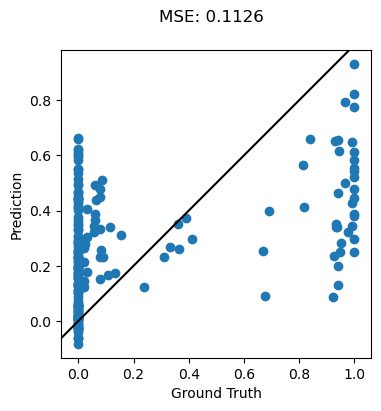

In [10]:
evaluate_model(dfs_list[2], y_test, y_pred)

In [ ]:


mean_squared_error(y_test, y_pred)



rfr = dcv.RandomizedSearchCV(model, search_grid, n_iter=50, cv=3)
rfr.fit(X_train, y_train)

baselines.evaluate_model(rfr, dfs_list[0], X_train, y_train)

In [3]:
### USER INPUTS ###
resolution_lat, resolution_lon = 0.01, 0.01
lats = [-34, 0]
lons = [130, 170]

train_val_test_frac = [0.7, 0.15, 0.15]
model_type = "rf"

gt = "unep_coral_presence"
exclude_list = []  # variables to exclude in prediction


In [4]:
### DATA ###
# buffered cmip6 xa.Dataset
cmip6_fp = (
    Path(config.cmip6_data_folder)
    / "BCC-CSM2-HR/r1i1p1f1/uo_so_vo_thetao_tos_buffered.nc"
)
cmip6_xa = xa.open_dataset(cmip6_fp)

# gebco bathymetry fp
gebco_fp = (
    Path(config.bathymetry_folder) / "gebco/gebco_2023_n0.0_s-40.0_w130.0_e170.0.nc"
)
gebco_xa = xa.open_dataset(gebco_fp)

# gebco slopes fp
gebco_slopes_fp = (
    Path(config.bathymetry_folder)
    / "gebco/gebco_2023_n0.0_s-40.0_w130.0_e170.0_slopes.nc"
)
gebco_slopes_xa = xa.open_dataset(gebco_slopes_fp)

# unep_wcmc shp fp
unep_fp = Path(config.gt_folder) / "unep_wcmc/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp"
unep_gdf = gpd.read_file(unep_fp)

# generate gt raster
unep_raster = functions_creche.rasterize_geodf(
    unep_gdf, resolution_lat=resolution_lat, resolution_lon=resolution_lon
)
# generate gt xarray
unep_xa = functions_creche.raster_to_xarray(
    unep_raster,
    x_y_limits=functions_creche.lat_lon_vals_from_geo_df(unep_gdf)[:4],
    resolution_lat=resolution_lat,
    resolution_lon=resolution_lon,
    name="unep_coral_presence",
)

In [5]:
### PREPROCESSING ###

# derive
if model_type == "rf":
    # compute stats df
    cmip6_xa = functions_creche.calculate_statistics(cmip6_xa)

# spatially align datasets into a single xarray dataset
input_dss = [
    spatial_data.process_xa_d(xa_d)
    for xa_d in [cmip6_xa, gebco_xa, gebco_slopes_xa, unep_xa]
]
common_dataset = functions_creche.spatially_combine_xa_d_list(
    input_dss, lats, lons, resolution_lat, resolution_lon
)


calculating statistics for 5 variables...: 0it [00:00, ?it/s]/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
calculating statistics for 5 variables...: 1it [00:01,  1.10s/it]/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype

In [6]:
common_dataset

<xarray.Dataset>
Dimensions:                (latitude: 3400, longitude: 4000)
Coordinates:
  * latitude               (latitude) float64 -34.0 -33.99 ... -0.02 -0.01
  * longitude              (longitude) float64 130.0 130.0 130.0 ... 170.0 170.0
    spatial_ref            int64 0
    crs                    int64 0
Data variables: (12/203)
    so_january_mean        (latitude, longitude) float32 dask.array<chunksize=(3400, 4000), meta=np.ndarray>
    so_february_mean       (latitude, longitude) float32 dask.array<chunksize=(3400, 4000), meta=np.ndarray>
    so_march_mean          (latitude, longitude) float32 dask.array<chunksize=(3400, 4000), meta=np.ndarray>
    so_april_mean          (latitude, longitude) float32 dask.array<chunksize=(3400, 4000), meta=np.ndarray>
    so_may_mean            (latitude, longitude) float32 dask.array<chunksize=(3400, 4000), meta=np.ndarray>
    so_june_mean           (latitude, longitude) float32 dask.array<chunksize=(3400, 4000), meta=np.ndarray>
    ...                     ...
    vo_jan_std             (latitude, longitude) float32 dask.array<chunksize=(3400, 4000), meta=np.ndarray>
    vo_jul_std             (latitude, longitude) float32 dask.array<chunksize=(3400, 4000), meta=np.ndarray>
    vo_overall_mean        (latitude, longitude) float32 dask.array<chunksize=(3400, 4000), meta=np.ndarray>
    elevation              (latitude, longitude) float64 dask.array<chunksize=(3400, 4000), meta=np.ndarray>
    seafloor_slope         (latitude, longitude) float64 dask.array<chunksize=(3400, 4000), meta=np.ndarray>
    unep_coral_presence    (latitude, longitude) float64 dask.array<chunksize=(3400, 4000), meta=np.ndarray>

In [10]:
if model_type == "rf":
    train_val_test_frac = [0.8, 0, 0.2]
    common_df = common_dataset.to_dask_dataframe()

In [11]:
common_df

,latitude,longitude,spatial_ref,crs,so_january_mean,so_february_mean,so_march_mean,so_april_mean,so_may_mean,so_june_mean,so_july_mean,so_august_mean,so_september_mean,so_october_mean,so_november_mean,so_december_mean,so_january_max,so_january_min,so_february_max,so_february_min,so_march_max,so_march_min,so_april_max,so_april_min,so_may_max,so_may_min,so_june_max,so_june_min,so_july_max,so_july_min,so_august_max,so_august_min,so_september_max,so_september_min,so_october_max,so_october_min,so_november_max,so_november_min,so_december_max,so_december_min,so_time_std,so_jan_std,so_jul_std,so_overall_mean,thetao_january_mean,thetao_february_mean,thetao_march_mean,thetao_april_mean,thetao_may_mean,thetao_june_mean,thetao_july_mean,thetao_august_mean,thetao_september_mean,thetao_october_mean,thetao_november_mean,thetao_december_mean,thetao_january_max,thetao_january_min,thetao_february_max,thetao_february_min,thetao_march_max,thetao_march_min,thetao_april_max,thetao_april_min,thetao_may_max,thetao_may_min,thetao_june_max,thetao_june_min,thetao_july_max,thetao_july_min,thetao_august_max,thetao_august_min,thetao_september_max,thetao_september_min,thetao_october_max,thetao_october_min,thetao_november_max,thetao_november_min,thetao_december_max,thetao_december_min,thetao_time_std,thetao_jan_std,thetao_jul_std,thetao_overall_mean,tos_january_mean,tos_february_mean,tos_march_mean,tos_april_mean,tos_may_mean,tos_june_mean,tos_july_mean,tos_august_mean,tos_september_mean,tos_october_mean,tos_november_mean,tos_december_mean,tos_january_max,tos_january_min,tos_february_max,tos_february_min,tos_march_max,tos_march_min,tos_april_max,tos_april_min,tos_may_max,tos_may_min,tos_june_max,tos_june_min,tos_july_max,tos_july_min,tos_august_max,tos_august_min,tos_september_max,tos_september_min,tos_october_max,tos_october_min,tos_november_max,tos_november_min,tos_december_max,tos_december_min,tos_time_std,tos_jan_std,tos_jul_std,tos_overall_mean,uo_january_mean,uo_february_mean,uo_march_mean,uo_april_mean,uo_may_mean,uo_june_mean,uo_july_mean,uo_august_mean,uo_september_mean,uo_october_mean,uo_november_mean,uo_december_mean,uo_january_max,uo_january_min,uo_february_max,uo_february_min,uo_march_max,uo_march_min,uo_april_max,uo_april_min,uo_may_max,uo_may_min,uo_june_max,uo_june_min,uo_july_max,uo_july_min,uo_august_max,uo_august_min,uo_september_max,uo_september_min,uo_october_max,uo_october_min,uo_november_max,uo_november_min,uo_december_max,uo_december_min,uo_time_std,uo_jan_std,uo_jul_std,uo_overall_mean,vo_january_mean,vo_february_mean,vo_march_mean,vo_april_mean,vo_may_mean,vo_june_mean,vo_july_mean,vo_august_mean,vo_september_mean,vo_october_mean,vo_november_mean,vo_december_mean,vo_january_max,vo_january_min,vo_february_max,vo_february_min,vo_march_max,vo_march_min,vo_april_max,vo_april_min,vo_may_max,vo_may_min,vo_june_max,vo_june_min,vo_july_max,vo_july_min,vo_august_max,vo_august_min,vo_september_max,vo_september_min,vo_october_max,vo_october_min,vo_november_max,vo_november_min,vo_december_max,vo_december_min,vo_time_std,vo_jan_std,vo_jul_std,vo_overall_mean,elevation,seafloor_slope,unep_coral_presence
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,

In [ ]:

    exclude_list += ["crs", "depth", "spatial_ref"]
    predictors = [
        pred for pred in common_df.columns if pred != gt and pred not in exclude_list
    ]

    (
        (X_train, y_train),
        (_, _),
        (X_test, y_test),
    ), dfs_list = functions_creche.process_df_for_rfr(
        common_df, predictors, gt, train_val_test_frac=train_val_test_frac
    )


0.027208640350950573

In [ ]:
#     print("fitting RandomizedSearchCV...")
#     # train_random_model
#     random_model = baselines.train_tune(
#         X_train,
#         y_train,
#         "rf_reg",
#         n_iter=2,
#         cv=2,
#         name="first_random",
#         search_type="random",
#         n_jobs=-1,
#         verbose=0,
#     )

#     print(random_model.best_estimator_)

In [ ]:
# baselines.evaluate_model(random_model, dfs_list[0], X_train, y_train)

In [ ]:
# from sklearn.externals.joblib import parallel_backend

# search = RandomizedSearchCV(model, search_grid, cv=10, n_iter=1000, verbose=0)

# with parallel_backend('dask', scheduler_host='your_scheduler_host:your_port'):
#         search.fit(digits.data, digits.target)

In [ ]:
# # grid search
# best_params_dict = random_model.best_params_

# grid_model = baselines.train_tune(
#     X_train, y_train, "rf_reg", name="first_grid", search_type="grid", n_jobs=-1, verbose=0, best_params_dict=best_params_dict)